<a href="https://colab.research.google.com/github/KwasiArhin/Movie_Capstone/blob/master/Torch_Capstone_Movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Background

Analysing cinema is a time-consuming process. In the cinematography domain alone, there's a lot of factors to consider, such as shot scale, shot composition, camera movement, color, lighting, etc. Whatever you shoot is in some way influenced by what you've watched. There's only so much one can watch, and even lesser that one can analyse thoroughly.

This is where neural networks offer ample promise. They can recognise patterns in images that weren't possible until less than a decade ago, thus offering an unimaginable speed up in analysing cinema. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
path = Path('/content/drive/My Drive/Shot Classification Capstone/Train')

In [0]:
path.ls()

[PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/ECU'),
 PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/EWS'),
 PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/LS'),
 PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/MCU'),
 PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/CU'),
 PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/Untitled0.ipynb'),
 PosixPath('/content/drive/My Drive/Shot Classification Capstone/Train/MS')]

# The Dataset


There is no public dataset that categorises cinematic shots into shot types. There is a prior research project that classified shot types using neural networks, but the dataset, although massive (~400,000 images), only had 3 output classes (shot types) from 120 films.

Thus, the dataset for this project had to be constructed from scratch. It is diverse, consisting of samples from over 300 movies, collected from various sources. Each image had to be looked over several times to ensure that it had been categorised correctly. 

In total, the dataset consists of 2,724 (2,180 training + 544 validation) images, split into 6 shot types:

1. Long Shot: 263 images 
2. Medium Shot: 142 images
3. Medium Close Up: 223 images
4. Close Up: 841 images
5. Extreme Close Up:1041 images
6. Extreme Wide Shot:210 images

Defining Input Aspect Ratio 
Since most films are shot in 16:9 aspect ratio, the model will take in input images that are transformed to the same aspect ratios

Note: input images img_size will be that of (base_size, 1.7777 * base_size)

In [0]:
base_size = 64
to_film_ar = lambda height: (height, int(height * 16/9))

In [0]:
img_size = to_film_ar(base_size)

## Data Transformations 

These Transformations specified below will be use to augment data and artifically generate more images to train on.

In [0]:
def xtra_tfms(base_size = base_size): 
    box_dim = int(base_size/4)
    #cutout_ = partial(cutout, p = .8,   n_holes = (20, 20), length = (box_dim, box_dim))
    cutout_ = partial(cutout, p = .8, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = 0.5,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p = 0.5, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p = 0.5, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p = 0.5, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p = 0.5, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p = 0.5, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    #dihedral_  = partial(dihedral, ())
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

In [0]:

def get_tfms(): return get_transforms(do_flip = True,
                                      flip_vert = False,
                                      max_zoom = 1.,
                                      max_lighting = 0.4,
                                      max_warp = 0.3,
                                      p_affine = 0.85,
                                      p_lighting = 0.85,
                                      xtra_tfms = xtra_tfms())

## Data Setup 

In [0]:
bs = 64
base_size = 75

tfms = get_tfms()
img_size = to_film_ar(base_size)

img_size

(75, 133)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=img_size, bs=bs, 
        resize_method = ResizeMethod.SQUISH,
        num_workers=4
        ).normalize(imagenet_stats)

## Samples of Data

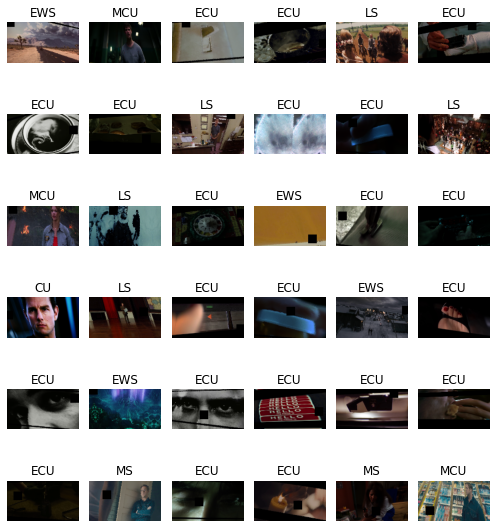

In [0]:
data.show_batch(rows=6, figsize=(7,8))

In [0]:
data.classes

['CU', 'ECU', 'EWS', 'LS', 'MCU', 'MS']

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['CU', 'ECU', 'EWS', 'LS', 'MCU', 'MS'], 6, 2180, 544)

# Shot Types

Extreme Wide Shot-An Extreme Wide Shot (EWS) emphasises the vastness of the location.When there is a subject, it usually occupies a very small part of the frame.

Long Shot-A Long Shot (LS) includes characters in their entirety, and a large portion of the surrounding area. 

Medium Shot- A Medium Shot (MS) shows the character from the waist up.It allows one to see nuances of the character's body language, and to some degree the facial expressions.

Medium Close Up-A Medium Close Up (MCU) shows the character from the chest/shoulders up.
It allows one to see nuances of the character's facial expressions, and some upper-body language.

Close Up-A Close Up (CU) shows the face of the character, sometimes including the neck/shoulders.Emphasises the facial expressions of the character.

Extreme Close Up-An Extreme Close Up (ECU) highly zooms in to any one feature of the subject to draw attention to that feature specifically. 

# Transfer Learning 

I utilized transfer learning techniques to acheive my results. Particularly I utilized the pouplart RESNET architecture which has proven reliable in image classification problems. With the fastai library its easy to call upon these archtectiutre with ease.  

# Training RESNET34

In [0]:
learn34 = cnn_learner(data, models.resnet34, metrics = [accuracy], pretrained=True)
learn34 = learn34.to_fp16()

# learn34.lr_find()
# learn34.recorder.plot()

In [0]:
learn34.fit_one_cycle(4, slice(3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.802568,0.451707,0.167279,00:53
1,1.099042,0.347845,0.110294,00:54
2,0.827052,0.352622,0.106618,00:54
3,0.678916,0.305148,0.097426,00:53


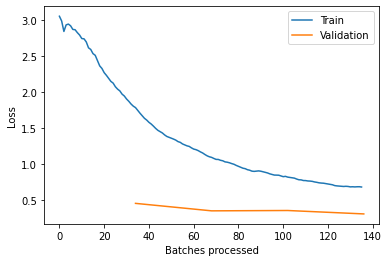

In [0]:
learn34.recorder.plot_losses()

In [0]:
learn34.save('learn34-1-1')

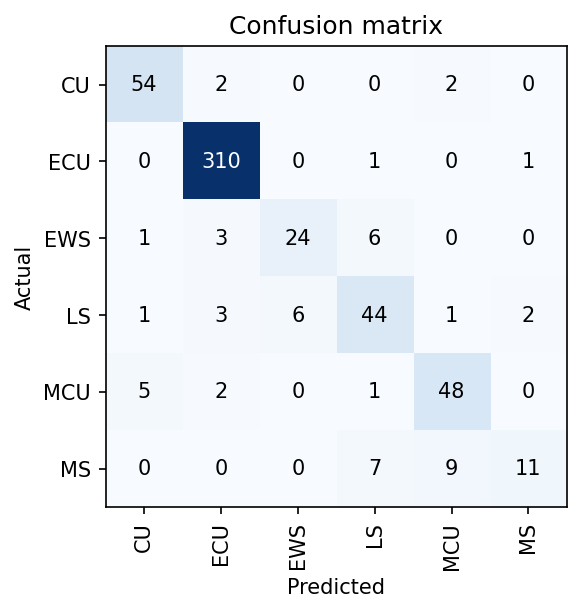

In [0]:
learn34.load('learn34-1-1');
interp = ClassificationInterpretation.from_learner(learn34)
interp.plot_confusion_matrix(dpi = 150)

The Resnet 34 perfomed quite well, will compare to a RESNET50 and see which performs better. If they are perform the same it would maybe worth it to use a resnet34 as there will be less layers. 

# Training RESNET50

In [0]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy], pretrained=True)
learn = learn.to_fp16()

# learn.lr_find()
# learn.recorder.plot()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn.fit_one_cycle(4, slice(3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.332482,0.492441,0.863971,00:55
1,0.898317,0.408261,0.895221,00:55
2,0.651172,0.269076,0.906250,00:54
3,0.497361,0.244139,0.920956,00:54


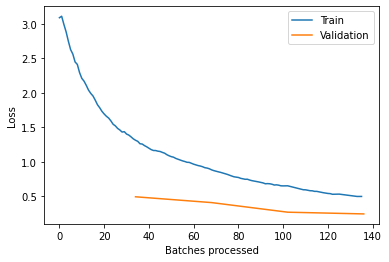

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-1')

## Interpretation

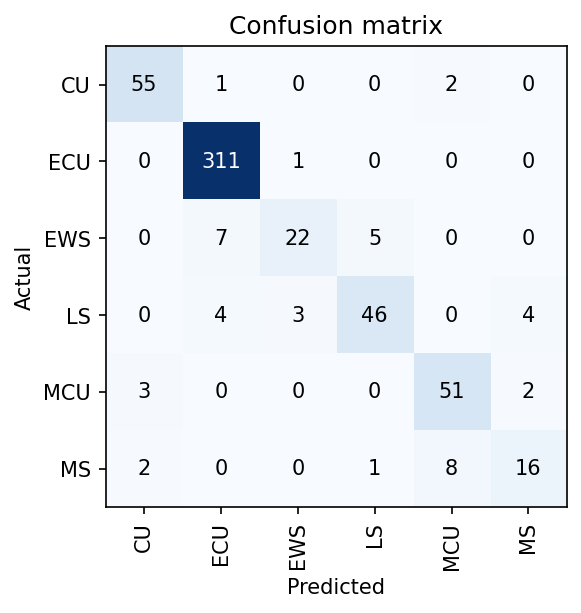

In [0]:
learn.load('stage-1-1');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

# Fine Tuning 

In [0]:
learn.load('stage-1-1');

In [0]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.381647,0.244920,0.915441,00:52
1,0.349132,0.216494,0.926471,00:52
2,0.319437,0.197875,0.933824,00:52
3,0.301922,0.191766,0.939338,00:52
4,0.287035,0.183362,0.941176,00:53
5,0.238584,0.181880,0.941176,00:53
6,0.228754,0.178362,0.943015,00:53
7,0.230495,0.174480,0.944853,00:53


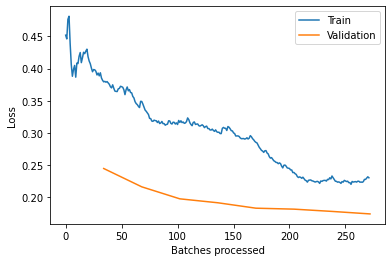

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-2')

Interpreting 

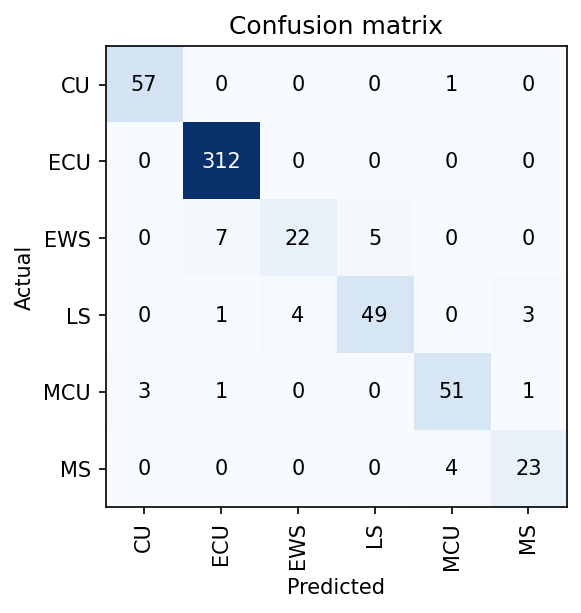

In [0]:
learn.load('stage-1-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

Extreme Closups are perfectly classified, while the closeups are near perfect too. The model needs more info for the other categories to work correctly. The dataset would have to be expanded to become even stronger. But with just a few epochs of work we have a very high performing and working model. 

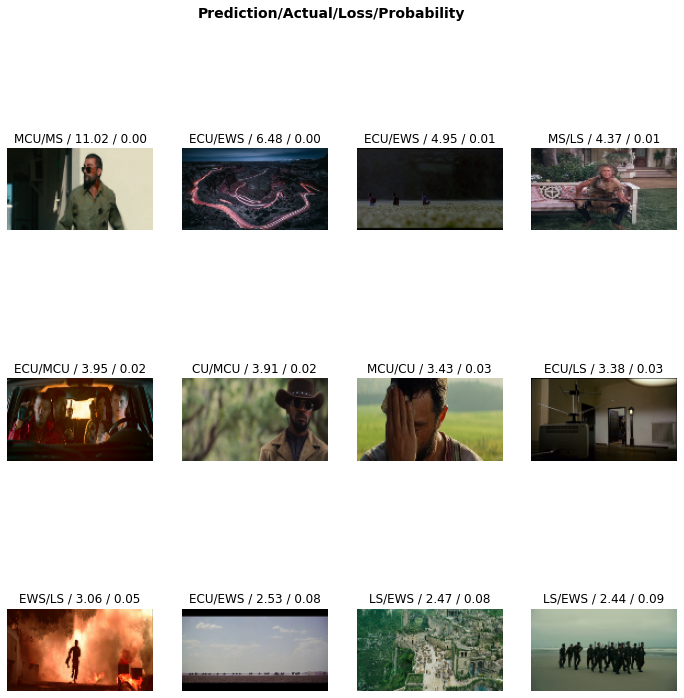

In [0]:
interp.plot_top_losses(12)

This visually gives something to look and see where the model is having some issues. The bigger the dataset though the more it will work more effective. The picture on the bottom right even shows the human error in labeling so in this case the model was correct. 

Even though we are getting great accuracy with our model there is still alot of work to do. Most of it has to do with the dataset, which has to be built out bigger. Because as we can see the model has learned ecu well because of the sheer number of them in our dataset. 

In [0]:
data.classes

['CU', 'ECU', 'EWS', 'LS', 'MCU', 'MS']

In [0]:
img = open_image('/content/drive/My Drive/Shot Classification Capstone/Train/CU/Drive-Scene-076-02.jpg')

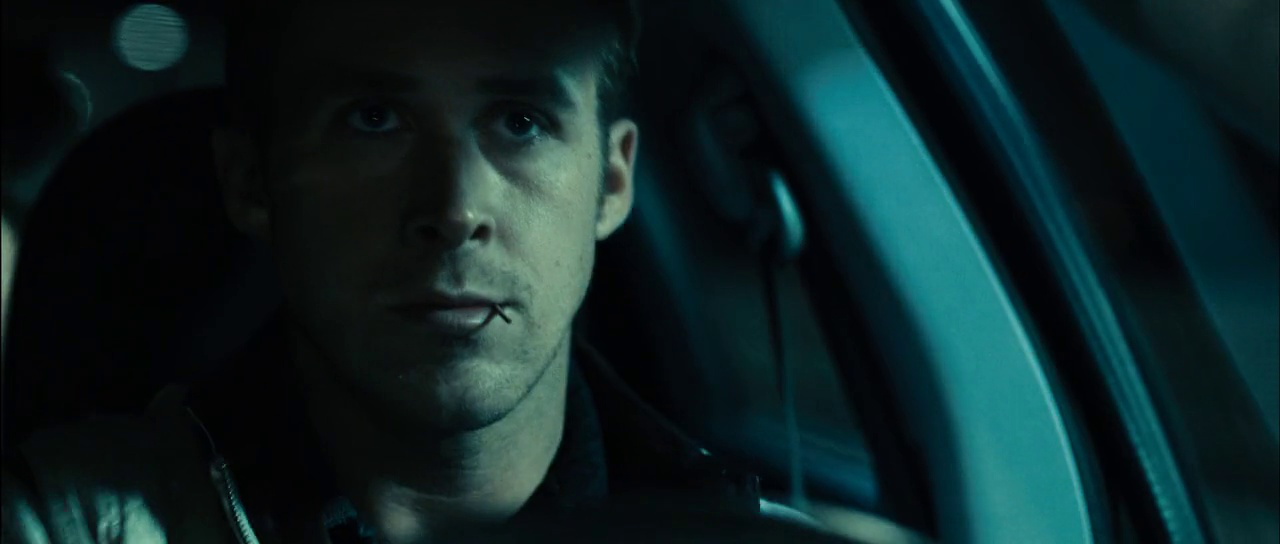

In [0]:
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)

In [0]:
pred_class

Category CU

My model was able to correctly the above image as a closeup.
So even with its faults it still is a strong performer. 